In [79]:
import os
import string
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence

import torchvision.models as models
from torchvision import transforms

import torchaudio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
class TextTransform:
    """ Maps characters to integers and vice versa """
    def __init__(self):
        char_map_str = """
            ' 0
            <SPACE> 1
            a 2
            b 3
            c 4
            d 5
            e 6
            f 7
            g 8
            h 9
            i 10
            j 11
            k 12
            l 13
            m 14
            n 15
            o 16
            p 17
            q 18
            r 19
            s 20
            t 21
            u 22
            v 23
            w 24
            x 25
            y 26
            z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence
    
    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('', ' ')
    
    def tensor_to_text(self, tensor):
        word = tensor.transpose(1,0)
        output = ['']*len(tensor)
        for i in range(len(tensor)):
            for j in range(28):
                if word[j][i] == 1: output[i] = self.index_map[j]
        print(output)
        return ''.join(output)

    def one_hot_enc(self, word):
        """ Returns a sequence of ones and zeros, result of one hot encoding """
        word = self.text_to_int(word)
        word = Variable(torch.tensor(word))
        word = torch.nn.functional.one_hot(word, len(self.index_map))
        return word.transpose(0, 1)

In [24]:
class SpeakDataset(Dataset):
    """ Pronunced words dataset """

    def __init__(self, csv_file: str, root_dir: str, audio_transform=None, text_transform=None):
        """ Args:
            csv_file (string): path to the csv file
            root_dir (string): directory with all the audio files
            transform (callable, optional): optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.audio_transform = audio_transform
        self.text_transform = TextTransform()
        self.data_labels = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        audio_name = os.path.join(self.root_dir, self.data_labels['filename'][idx])
        waveform, sample_rate = torchaudio.load(audio_name)
        word = self.data_labels["word"][idx]
        score = self.data_labels["score"][idx]
        
        # one hot encoding word
        label = self.text_transform.one_hot_enc(word)
        label = label.transpose(1,0)
        
        # spectrogram
        specgram = torchaudio.transforms.MelSpectrogram()(waveform)
        specgram = F.interpolate(specgram, size=len(word), mode="nearest")
        specgram = specgram.transpose(1,2)

        # convert to tensor
        score = score.split(';')
        score = list(map(int, score))
        score = torch.FloatTensor(score)
        
        if self.audio_transform:
            specgram = self.audio_transform(specgram)
        
        sample = { "specgram": specgram, "label": label, "score": score }

        return specgram, label, score

In [25]:
def pad_collate(batch):
    specgrams = [item[0].transpose(0,1) for item in batch]
    labels = [item[1] for item in batch]
    scores = [item[2] for item in batch]
    
    specgrams = pad_sequence(specgrams, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=0)
    scores = pad_sequence(scores, batch_first=True, padding_value=0)
    
    return specgrams, labels, scores

In [39]:
# testing the audio preprocessing pipeline
batch_size=4
dataset = SpeakDataset(csv_file='data.csv', root_dir='data')
train_data = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, collate_fn=pad_collate)
text_transformer = TextTransform()

torch.Size([4, 8])
Shape of spectrogram: torch.Size([4, 8, 2, 128])
Shape of labels: torch.Size([4, 8, 28])
['d', 'o', 'g', '', '', '', '', '']
torch.Size([2, 8, 128])
['l', 'o', 'v', 'e', '', '', '', '']
torch.Size([2, 8, 128])
['w', 'o', 'r', 'l', 'd', '', '', '']
torch.Size([2, 8, 128])
['b', 'u', 'i', 'l', 'd', 'i', 'n', 'g']
torch.Size([2, 8, 128])
torch.Size([4, 6])
Shape of spectrogram: torch.Size([4, 6, 2, 128])
Shape of labels: torch.Size([4, 6, 28])
['s', 't', 'r', 'e', 'e', 't']
torch.Size([2, 6, 128])
['t', 'o', 'd', 'a', 'y', '']
torch.Size([2, 6, 128])
['h', 'o', 'u', 's', 'e', '']
torch.Size([2, 6, 128])
['s', 'c', 'h', 'o', 'o', 'l']
torch.Size([2, 6, 128])
torch.Size([4, 9])
Shape of spectrogram: torch.Size([4, 9, 2, 128])
Shape of labels: torch.Size([4, 9, 28])
['d', 'o', 'n', 'e', '', '', '', '', '']
torch.Size([2, 9, 128])
['c', 'a', 't', '', '', '', '', '', '']
torch.Size([2, 9, 128])
['y', 'e', 's', 't', 'e', 'r', 'd', 'a', 'y']
torch.Size([2, 9, 128])
['h', 'o', 

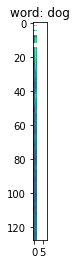

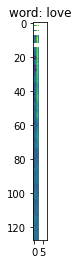

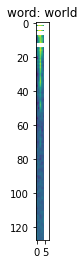

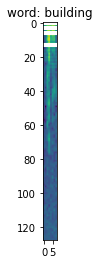

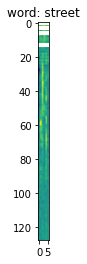

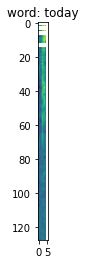

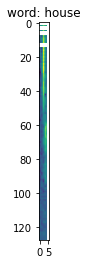

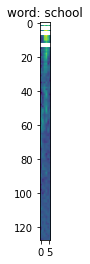

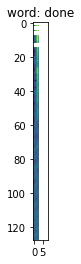

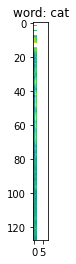

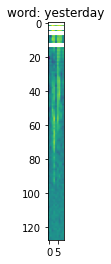

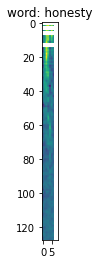

In [62]:
for idx, sample in enumerate(train_data):
    specgram, label, score = sample
    specgram.size()
    print(score.size())
    
    print(f"Shape of spectrogram: {specgram.size()}")
    print(f"Shape of labels: {label.size()}")
    
    for i in range(batch_size):
        spectogram = specgram[i].transpose(1,0)
        plt.figure()
        plt.title(f"word: {text_transformer.tensor_to_text(label[i])}")
        print(spectogram.size())
        spectogram = spectogram.transpose(1,2)
        plt.imshow(spectogram.log2()[0,:,:].detach().numpy())
    
    if idx > 1: break

In [50]:
class MVPModel(nn.Module):
    def __init__(self):
        super(MVPModel, self).__init__()
        self.rnn = nn.LSTM(input_size=128+28, hidden_size=20,
                           num_layers=2, bidirectional=True)
        self.fc = nn.Linear(40, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, specgram, label, initial_states):
        # initial states
        h0, c0 = initial_states
        
        x = torch.cat((label, specgram), 2)
        
        output, (hn, cn) = self.rnn(x, (h0, c0))
        output = self.fc(output)
        return self.softmax(output)

In [66]:
# testing the model i/o
model = MVPModel()

x = torch.randn(4,4,128)
y = torch.randn(4,4,28)

for idx, sample in enumerate(train_data):
    specgram, label, score = sample
    specgram = specgram[:,:,0,:]
    
    _, word_size, _ = label.size()
    
    print(specgram.size())
    print(label.size())
    
    # initial states
    h0 = torch.zeros(4,word_size,20)
    c0 = torch.zeros(4,word_size,20)
    
    output = model(specgram, label, (h0,c0))
    
    print(f"pred: {output[:,:,0].size()}, score: {score.size()}")
    
    # print(f"Shape of spectrogram: {specgram.size()}")
    # print(f"Shape of labels: {label.size()}")
    
    if idx > 1: break

# output = model(x, y)
# print(x.size(), output.size())
# print(output)

torch.Size([4, 5, 128])
torch.Size([4, 5, 28])
pred: torch.Size([4, 5]), score: torch.Size([4, 5])
torch.Size([4, 7, 128])
torch.Size([4, 7, 28])
pred: torch.Size([4, 7]), score: torch.Size([4, 7])
torch.Size([4, 8, 128])
torch.Size([4, 8, 28])
pred: torch.Size([4, 8]), score: torch.Size([4, 8])


In [126]:
def train(model, loss_fn,
         train_loader, valid_loader,
         epochs, optimizer, train_losses,
         valid_losses, change_lr=None):
    
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        batch_losses = []
        
    if change_lr:
        optimizer = change_lr(optimizer, epoch)
    
    for i, sample in enumerate(train_loader):
        specgram, label, score = sample
        specgram = specgram[:,:,0,:].to(device)
        label = label.to(device)
        score = score.to(device)
        _, word_size, _ = label.size()

        # initial states
        h0 = torch.ones(4,word_size,20)
        c0 = torch.ones(4,word_size,20)
        
        score_pred = model(specgram, label, (h0,c0))[:,:,0]
        
        loss = loss_fn(score_pred, score)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_score = []
    trace_score_pred = []
    
    for i, data in enumerate(valid_loader):
        specgram, label, score = sample
        specgram = specgram[:,:,0,:].to(device)
        label = label.to(device)
        score = score.to(device)
        _, word_size, _ = label.size()
        # print([text_transformer.tensor_to_text(label[i]) for i in range(len(label))])
        # print(f"specgram size: {specgram.size()}, label size: {label.size()}")

        # initial states
        h0 = torch.ones(4,word_size,20)
        c0 = torch.ones(4,word_size,20)
        
        score_pred = model(specgram, label, (h0,c0))[:,:,0]
        
        loss = loss_fn(score_pred, score)
        trace_score.append(score.cpu().detach().numpy())
        trace_score_pred.append(score_pred.cpu().detach().numpy())      
        batch_losses.append(loss.item())
    
    valid_losses.append(batch_losses)
    trace_score = np.concatenate(trace_score)
    trace_score_pred = np.concatenate(trace_score_pred)
    accuracy = np.mean(trace_score_pred.argmax(axis=1)==trace_score)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')
        

In [127]:
# load data
batch_size=4
dataset = SpeakDataset(csv_file='data.csv', root_dir='data')
train_loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, collate_fn=pad_collate)

text_transformer = TextTransform()

model = MVPModel()

learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.MSELoss()
train_losses=[]
valid_losses=[]

train(model, loss_fn,
      train_loader, valid_loader,
      epochs, optimizer,
      train_losses, valid_losses)

100%|██████████| 50/50 [00:00<00:00, 114535.88it/s]

Epoch - 50 Train-Loss : 0.5235017786423365
Epoch - 50 Valid-Loss : 0.4066477119922638 Valid-Accuracy : 0.0



/home/achraf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [123]:
def post_processing(label, score):
    print(f"label: {label}")
    label_len = len(label)
    real_len = 0
    j = 0
    
    while j < label_len:
        if label[j+1:] == [0]*28:
            real_len = j
            break
        j+=1
    
    return label[:j+1], score[:j+1]